Import packages

In [3]:
import pathlib
import numpy as np
import scanpy as sc
import pandas as pd

#pyscenic
import anndata as ad
from anndata.experimental.multi_files import AnnCollection

## This is T-SNE, download has wheel error, could fix... could use UM
#from MulticoreTSNE import MulticoreTSNE as TSNE

#data vis
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import umap

#scvi
import leidenalg
import igraph
import pymde
import torch
import tempfile
import scvi


d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
d:\Coding\

In [7]:
current_directory = pathlib.Path.cwd()
module_directory = current_directory.parent.parent

dataset_type = "heca_vsdisease"
output_path = module_directory / 'output'
scrna_input = output_path / 'cell_typist' /dataset_type/ "celltypist_annotated.h5ad"
scrna_output = output_path / 'integrated_scRNA' /dataset_type
other_output = output_path / 'scvi' / dataset_type
scrna_output/dataset_type

for path in [scrna_output, other_output]:
    if not path.exists():
        print(f"Directory {path} does not exist. Creating it now...")
        path.mkdir(parents=True, exist_ok=True)
    else:
        print(f"Directory {path} already exists.")

Directory d:\Coding\comp_bio\endometrial_analysis\output\integrated_scRNA\heca_vsdisease already exists.
Directory d:\Coding\comp_bio\endometrial_analysis\output\scvi\heca_vsdisease already exists.


In [5]:
import shutil

total, used, free = shutil.disk_usage("/")
print(f"Total: {total // (2**30)} GiB")
print(f"Used: {used // (2**30)} GiB")
print(f"Free: {free // (2**30)} GiB")

Total: 931 GiB
Used: 366 GiB
Free: 564 GiB


In [9]:
combined_adata = sc.read(scrna_input)


In [10]:
str(combined_adata)

"AnnData object with n_obs × n_vars = 114459 × 4000\n    obs: 'dataset', 'Menstrual Cycle Stage', 'Disease State', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_scvi_corr', 'leiden_scvi_euc', 'predicted_labels', 'majority_voting', 'conf_score', 'over_clustering'\n    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'\n    uns: 'Disease State_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'hvg', 'leiden_scvi_corr', 'leiden_scvi_corr_colors', 'leiden_scvi_euc', 'leiden_scvi_euc_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'neighbors_corr', 'neighbors_euc', 'over_clustering', 'pca', 'predicted_labels_colors', 'umap'\n    obsm: 'X_pca', 'X_scVI', 'X_scVI_MDE', 'X_umap'\n    varm: 'PCs'\n    layers: 'counts', 'oldX', 'scvi_expr'\n    obsp: 'conn

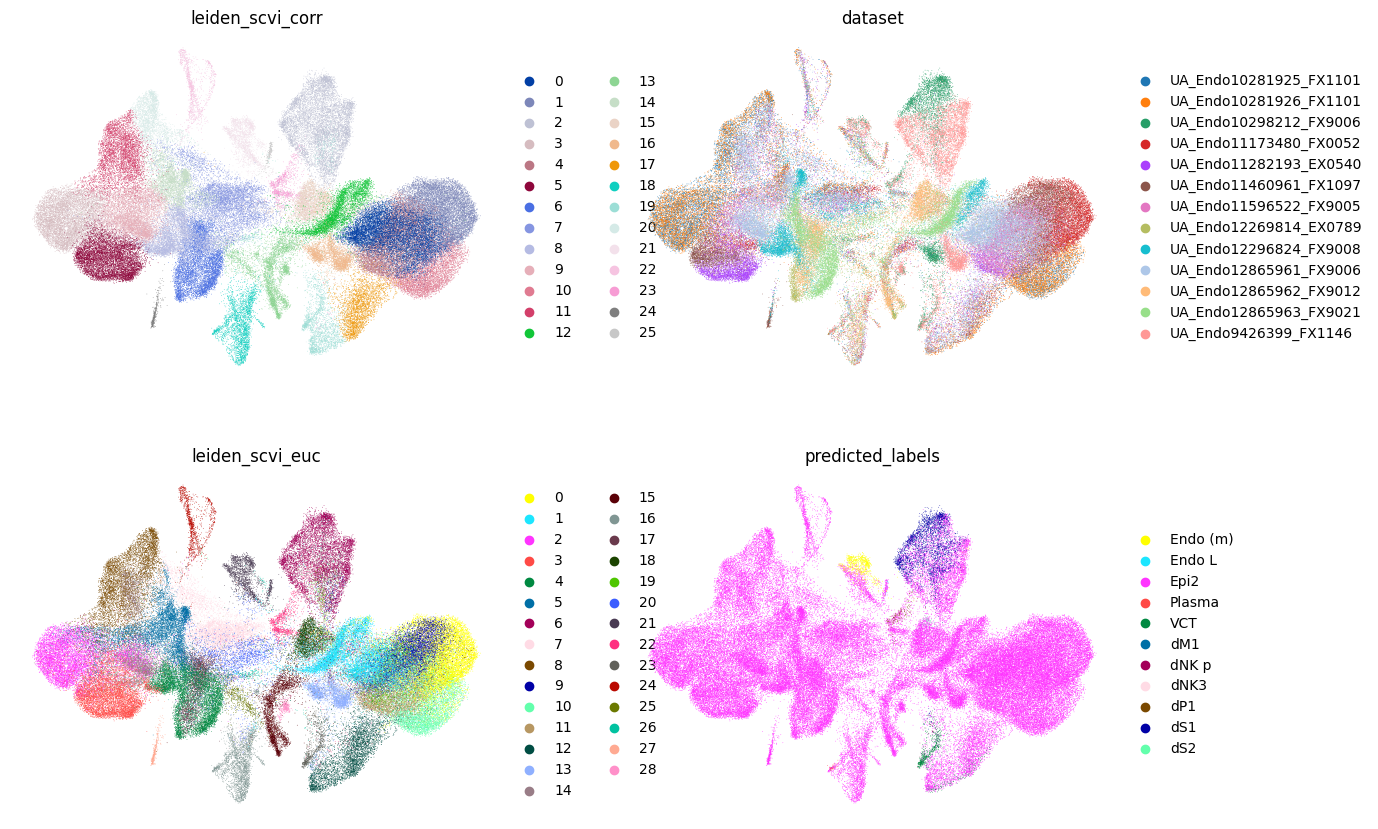

In [16]:

#result of umap compared to previous scvi embedding 
sc.pl.umap(
   combined_adata,
    color=["leiden_scvi_corr", 'dataset', 'leiden_scvi_euc', 'predicted_labels'],
    frameon=False,
    ncols=2
)



In [17]:


sc.tl.rank_genes_groups(combined_adata, groupby="predicted_labels")



In [ ]:

sc.tl.rank_genes_groups(
    combined_adata,
    groupby='Disease State',  # Group by the 'Disease State'
    reference='normal',      # Healthy tissue as the reference
    method='wilcoxon',        # Wilcoxon rank-sum test
)

In [ ]:
de_genes = pd.DataFrame(combined_adata.uns['rank_genes_groups']['names']).head(50)  # Top 50 DE genes
de_genes_list = de_genes.values.flatten().tolist()

# Calculate average expression of DE genes per cell type
cell_type_means = combined_adata.to_df().loc[:, de_genes_list].groupby(combined_adata.obs['predicted_labels']).mean()

# Identify the cell type most associated with DE genes
most_associated_celltype = cell_type_means.mean(axis=1).idxmax()
print(f"The most associated cell type is: {most_associated_celltype}")

In [ ]:
adata_subset = combined_adata.copy()  # Make a copy to avoid altering the original
specific_celltype = most_associated_celltype
celltype_subset = adata_subset[adata_subset.obs['predicted_labels'] == specific_celltype]

# Perform DE analysis within this cell type
sc.tl.rank_genes_groups(
    celltype_subset,
    groupby='Disease State',
    reference='normal',
    method='wilcoxon',
)

# Extract the DE gene list for this cell type
celltype_de_genes = pd.DataFrame({
    'names': celltype_subset.uns['rank_genes_groups']['names'],
    'scores': celltype_subset.uns['rank_genes_groups']['scores']
}).head(50)  # Top 50 DE genes
celltype_de_genes.to_csv(f'de_genes_{specific_celltype}_healthy_vs_endometriosis.csv', index=False)


In [18]:
sc.get.rank_genes_groups_df(combined_adata, group="Epi2")

,names,scores,logfoldchanges,pvals,pvals_adj
0,RHEX,360.029541,6.753291,0.0,0.0
1,AC024230.1,357.721832,7.041899,0.0,0.0
2,EYA2,308.196991,6.591888,0.0,0.0
3,NPAS3,265.418060,5.929787,0.0,0.0
4,LINC01541,258.724426,4.961521,0.0,0.0
...,...,...,...,...,...
33677,TPT1,-147.473877,-3.277449,0.0,0.0
33678,PTMA,-149.501678,-2.439558,0.0,0.0
33679,RPS15A,-149.613007,-3.619071,0.0,0.0
33680,MT-CYB,-150.708710,-4.035843,0.0,0.0


In [34]:
adata_subset = combined_adata.copy()  # Make a copy to avoid altering the original
celltype_subset = adata_subset[adata_subset.obs['predicted_labels'] == "Epi2"]

epi2_adata = celltype_subset[celltype_subset.obs["predicted_labels"] == "Epi2"].copy()  # Explicitly copy the subset

# Perform differential expression analysis
sc.tl.rank_genes_groups(
    epi2_adata,
    groupby="Disease State",  # Compare based on Disease State
    reference="normal",       # Use "normal" as the reference group
    method="wilcoxon",        # Use Wilcoxon rank-sum test
)




In [35]:
# Extract the DE results comparing "normal" to "endometriosis"
de_genes_epi2 = sc.get.rank_genes_groups_df(epi2_adata, group="endometriosis")

# Save the results to a CSV file
de_genes_epi2.to_csv("epi2_normal_vs_endometriosis.csv", index=False)

# Display the top genes
print(de_genes_epi2.head())

        names      scores  logfoldchanges  pvals  pvals_adj
0      ARGLU1  122.576675        1.113775    0.0        0.0
1  AC023424.3  121.619446        2.180046    0.0        0.0
2      MFSD4B  111.276230        1.269344    0.0        0.0
3        DDX5  107.516876        0.694968    0.0        0.0
4         PNN  103.115990        1.116630    0.0        0.0


In [19]:
model = scvi.model.SCVI.load(other_output, combined_adata)

INFO     File d:\Coding\comp_bio\endometrial_analysis\output\scvi\heca_vsdisease\model.pt already downloaded       


d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\scvi\model\base\_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = t

In [21]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=combined_adata,
    labels_key="predicted_labels",
    unlabeled_category="Unknown",
)

d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\scvi\data\fields\_dataframe_field.py:186: UserWarning: Category 5 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\scvi\data\fields\_scanvi.py:55: UserWarning: Category 5 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [22]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\Coding\comp_bio\endometrial_analysis\scripts\integration\.venv\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training:   0%|          | 0/20 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [23]:
SCANVI_LATENT_KEY = "X_scANVI"
combined_adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(combined_adata)

In [24]:
SCANVI_MDE_KEY = "X_scANVI_MDE"
combined_adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(combined_adata.obsm[SCANVI_LATENT_KEY])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


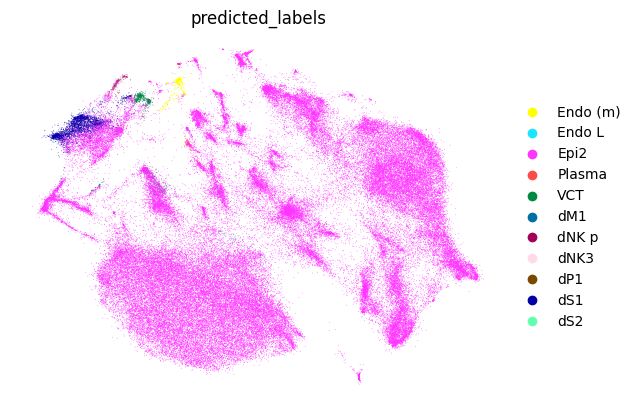

In [25]:
sc.pl.embedding(combined_adata, basis=SCANVI_MDE_KEY, color=["predicted_labels"], ncols=1, frameon=False)

In [29]:
!pip install scib-metrics

In [30]:
from scib_metrics.benchmark import Benchmarker
SCVI_LATENT_KEY = "X_scVI"
bm = Benchmarker(
    combined_adata,
    batch_key="dataset",
    label_key="predicted_labels",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

ModuleNotFoundError: No module named 'scib_metrics'

In [ ]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
df = bm.get_results(min_max_scale=False)
print(df)

In [ ]:
markers = {}
cats = combined_adata.obs.cell_types.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = full_de_res.loc[full_de_res.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_mean", ascending=False)

    # those genes with higher expression in group 1
    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]

    # significance
    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    # genes with sufficient expression
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:3]

In [ ]:
sc.tl.dendrogram(combined_adata, groupby="cell_types", use_rep="X_scvi")

In [ ]:


sc.pl.dotplot(
   combined_adata,
    markers,
    groupby='cell_types',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)



In [ ]:
sc.pl.matrixplot(
   combined_adata, 
    markers, 
    groupby='cell_types',
    standard_scale="var",
    layer="scvi_expr",
    dendrogram=True,
)

In [ ]:
sc.pl.rank_genes_groups_stacked_violin(combined_adata, n_genes=2)

In [ ]:


sc.pl.umap(combined_adata, color=["Ly6d", "Xcr1", "Foxp3"])
sc.pl.umap(combined_adata, color=["Ly6d", "Xcr1", "Foxp3"], layer="scvi_expr")



In [ ]:


sc.tl.embedding_density(combined_adata, groupby="tissue", key_added="tissue_density")



In [ ]:
sc.pl.umap(combined_adata, color=["cell_types", "tissue"], ncols=1)

In [ ]:
sc.pl.embedding_density(combined_adata, key="tissue_density")

In [ ]:
sc.tl.rank_genes_groups(combined_adata, 'louvain', method='t-test')

In [ ]:
sc.pl.rank_genes_groups(combined_adata, n_genes=20, sharey=False)